
# Sensor + Image Dual-Output Model (Keras/TensorFlow)

This notebook builds a dual-input neural network that combines **sensor time-series snapshots** with **camera images** to predict two targets:

- **img_output** (2 classes): `good_h` vs `bad_h` based on image labels
- **cond_output** (5 classes): plant condition based on sensor JSON (`Healthy`, `Overwatered`, `Lightly underwatered`, `Shocked`, `Overdried`)

It performs:
- Load & parse sensor JSON (`sensor_log_new.json`) with timestamp normalization and numerical scaling (`StandardScaler`).
- Load images from `AWSimages - labeled/`, parse filenames like `good_h.08-03_10-10.jpeg` to extract **day** and **time** and binary label (`good_h` / `bad_h`).
- **Match each sensor datapoint** to the **nearest image on the same day** (in minutes). If a sensor datapoint has no same-day image, it is **kept** and its image is set to a **zero tensor**; its contribution to the `img_output` loss is **masked** via `sample_weight`.
- Build a **dual-branch model**:
  - **Image branch**: `MobileNetV2` (ImageNet weights, frozen, `pooling='avg'`) with light data augmentation.
  - **Sensor branch**: `Dense(32, relu) → Dropout(0.3) → Dense(16, relu)`.
  - Merge → `Dense(64, relu) → Dropout(0.4)` → two softmax heads: `img_output` (2) and `cond_output` (5).
- Compile with `Adam(1e-3)` and `SparseCategoricalCrossentropy` for both outputs; metric: `accuracy`.
- Chronological train/validation split (80/20) by sensor timestamp.
- Early stopping on `val_cond_output_accuracy` with `patience=8`, restoring best weights.
- Save trained model as **`sensor_image_model.h5`**.


## 1) Environment & Imports

In [4]:
# install dependencies
# !pip -q install tensorflow==2.15.* pandas scikit-learn pillow matplotlib

import os
from pathlib import Path
import re
import json
import math
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from tensorflow.keras.applications import MobileNetV2

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

print(tf.__version__)


2.11.0


## 2) Configuration

In [5]:

# Paths
SENSOR_JSON_PATH = Path("sensor_log_new.json")           # JSON file with sensor readings
IMAGES_DIR = Path("AWSimages-labeled")                 # Folder containing labeled images

# Image settings
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3

# Training settings
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
PATIENCE = 8

# Expected labels
IMG_LABELS = ["bad_h", "good_h"]  # mapped to {bad_h:0, good_h:1}
COND_LABELS_EXPECTED = ["Healthy", "OverW", "SUnderW", "Shocked", "UnderW"]


## 3) Load Sensor JSON, Parse Timestamps, Scale Numerics

In [6]:

assert SENSOR_JSON_PATH.exists(), f"Missing {SENSOR_JSON_PATH}. Place it next to this notebook."

# Load
df = pd.read_json(SENSOR_JSON_PATH)

# Basic schema checks
required_cols = ["timestamp", "temp", "moist", "brightness", "green", "label"]
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing required columns in JSON: {missing}"

# Parse timestamp (MM-DD HH:MM)
def parse_sensor_ts(s: str):
    # Allow flexible formats
    return pd.to_datetime(s, format="%m-%d %H:%M", errors="coerce")

df["timestamp_dt"] = df["timestamp"].apply(parse_sensor_ts)
assert df["timestamp_dt"].notna().all(), "Some timestamps failed to parse. Check format 'MM-DD HH:MM'."

# Derive helpers: month-day key and minute-of-day
df["md_key"] = df["timestamp_dt"].dt.strftime("%m-%d")
df["minute_of_day"] = df["timestamp_dt"].dt.hour * 60 + df["timestamp_dt"].dt.minute

# Validate condition labels (cond_output)
unique_cond = sorted(df["label"].astype(str).unique().tolist())
unexpected = [u for u in unique_cond if u not in COND_LABELS_EXPECTED]
if unexpected:
    print("Warning: Found unexpected condition labels:", unexpected)
    # Merge into expected list deterministically to index everything
    cond_labels = sorted(set(COND_LABELS_EXPECTED + unique_cond))
else:
    cond_labels = COND_LABELS_EXPECTED.copy()

cond_label_to_idx = {c:i for i,c in enumerate(cond_labels)}
cond_idx_to_label = {i:c for c,i in cond_label_to_idx.items()}

print("Condition labels mapping:", cond_label_to_idx)

# Scale numerical features
num_cols = ["temp", "moist", "brightness", "green"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols].values.astype(np.float32))

print("Loaded sensor rows:", len(df))
df.head()


Condition labels mapping: {'Healthy': 0, 'Lightly underwatered': 1, 'OverW': 2, 'Overdried': 3, 'Overwatered': 4, 'SUnderW': 5, 'Shocked': 6, 'UnderW': 7}
Loaded sensor rows: 552


,timestamp,temp,moist,brightness,green,label,liveOnly,timestamp_dt,md_key,minute_of_day
0,07-14 21:45,-0.006861,-1.213585,0.042601,0.042601,Healthy,NaN,1900-07-14 21:45:00,07-14,1305
1,07-15 05:45,-0.648987,-1.459932,0.042601,0.042601,Healthy,NaN,1900-07-15 05:45:00,07-15,345
2,07-15 06:15,-0.769966,-0.720892,0.042601,0.042601,Healthy,NaN,1900-07-15 06:15:00,07-15,375
3,07-15 06:45,-0.769966,-1.172527,0.042601,0.042601,Healthy,NaN,1900-07-15 06:45:00,07-15,405
4,07-15 07:15,-0.825804,-1.131470,0.042601,0.042601,Healthy,NaN,1900-07-15 07:15:00,07-15,435


## 4) Load Images, Parse Filenames, Build Image Index

In [7]:

assert IMAGES_DIR.exists(), f"Missing image directory: {IMAGES_DIR}"

image_records = []
img_pattern = re.compile(r'^(good_h|bad_h)\.(\d{2})-(\d{2})_(\d{2})-(\d{2})', re.IGNORECASE)

valid_exts = {".jpg", ".jpeg", ".png"}
for root, _, files in os.walk(IMAGES_DIR):
    for fname in files:
        ext = Path(fname).suffix.lower()
        if ext not in valid_exts:
            continue
        m = img_pattern.match(fname)
        if not m:
            # Skip files that don't conform to expected pattern
            continue
        label_raw, mm, dd, HH, MM = m.groups()
        label = label_raw.lower()
        mmdd = f"{int(mm):02d}-{int(dd):02d}"
        minute_of_day = int(HH) * 60 + int(MM)
        fpath = str(Path(root) / fname)
        image_records.append({
            "filepath": fpath,
            "img_label": label,           # 'good_h' or 'bad_h'
            "md_key": mmdd,               # month-day
            "minute_of_day": minute_of_day
        })

img_df = pd.DataFrame(image_records)
if img_df.empty:
    print("No valid images found matching the expected pattern. Proceeding with zero-image tensors for all samples.")
else:
    # Normalize label case and validate
    img_df["img_label"] = img_df["img_label"].str.lower()
    valid_img_labels = set(IMG_LABELS)
    unexpected_img_labels = sorted(set(img_df["img_label"]) - valid_img_labels)
    assert not unexpected_img_labels, f"Unexpected image labels: {unexpected_img_labels}"
    print("Loaded images:", len(img_df))

img_df.head() if not img_df.empty else img_df


Loaded images: 71


,filepath,img_label,md_key,minute_of_day
0,AWSimages-labeled\bad_h.07-15_21-20.jpg,bad_h,07-15,1280
1,AWSimages-labeled\bad_h.07-16_06-10.jpg,bad_h,07-16,370
2,AWSimages-labeled\bad_h.07-16_10-10.jpg,bad_h,07-16,610
3,AWSimages-labeled\bad_h.07-16_14-10.jpg,bad_h,07-16,850
4,AWSimages-labeled\bad_h.07-16_21-20.jpg,bad_h,07-16,1280


## 5) Match Each Sensor Row to the Nearest Same-Day Image

In [8]:

# For each sensor row, find closest image (absolute minutes difference) on the same md_key.
def find_closest_image(row, group):
    # group is img_df subset for the same md_key
    if group is None or group.empty:
        return pd.Series({"matched_img_path": None, "matched_img_label": None, "time_diff": None})
    diffs = np.abs(group["minute_of_day"].values - row["minute_of_day"])
    idx = diffs.argmin()
    best = group.iloc[idx]
    return pd.Series({"matched_img_path": best["filepath"], "matched_img_label": best["img_label"], "time_diff": int(diffs[idx])})

if img_df.empty:
    match_cols = df.apply(lambda r: pd.Series({"matched_img_path": None, "matched_img_label": None, "time_diff": None}), axis=1)
else:
    # Pre-group images by md_key for efficiency
    img_groups = {k: g.reset_index(drop=True) for k, g in img_df.groupby("md_key")}
    match_cols = df.apply(lambda r: find_closest_image(r, img_groups.get(r["md_key"])), axis=1)

df = pd.concat([df, match_cols], axis=1)
print("Matched images (some may be None if no same-day image existed).")
df[["timestamp", "md_key", "minute_of_day", "matched_img_path", "matched_img_label", "time_diff"]].head(10)


Matched images (some may be None if no same-day image existed).


,timestamp,md_key,minute_of_day,matched_img_path,matched_img_label,time_diff
0,07-14 21:45,07-14,1305,AWSimages-labeled\good_h.07-14_21-20.jpg,good_h,25.0
1,07-15 05:45,07-15,345,AWSimages-labeled\good_h.07-15_06-10.jpg,good_h,25.0
2,07-15 06:15,07-15,375,AWSimages-labeled\good_h.07-15_06-10.jpg,good_h,5.0
3,07-15 06:45,07-15,405,AWSimages-labeled\good_h.07-15_06-10.jpg,good_h,35.0
4,07-15 07:15,07-15,435,AWSimages-labeled\good_h.07-15_06-10.jpg,good_h,65.0
5,07-15 07:45,07-15,465,AWSimages-labeled\good_h.07-15_06-10.jpg,good_h,95.0
6,07-15 08:15,07-15,495,AWSimages-labeled\good_h.07-15_10-10.jpg,good_h,115.0
7,07-15 08:45,07-15,525,AWSimages-labeled\good_h.07-15_10-10.jpg,good_h,85.0
8,07-15 09:15,07-15,555,AWSimages-labeled\good_h.07-15_10-10.jpg,good_h,55.0
9,07-15 09:45,07-15,585,AWSimages-labeled\good_h.07-15_10-10.jpg,good_h,25.0


## 6) Prepare Tensors & Labels (Sensors + Images)

In [9]:

# Sensor features
X_sensor = df[["temp", "moist", "brightness", "green"]].values.astype(np.float32)

# Condition labels (cond_output), integers for SparseCategoricalCrossentropy
y_cond = df["label"].map(cond_label_to_idx).values.astype(np.int64)

# Image labels (img_output): map to integers; if missing image, use placeholder 0 but weight=0
img_label_to_idx = {lab:i for i, lab in enumerate(IMG_LABELS)}
img_has = df["matched_img_label"].notna().values
y_img = np.where(img_has, df["matched_img_label"].map(img_label_to_idx).fillna(0).values, 0).astype(np.int64)

# Sample weights: missing images get weight 0 for the img_output head
sw_img = img_has.astype(np.float32)  # 1.0 if have image, else 0.0
sw_cond = np.ones_like(sw_img, dtype=np.float32)

# Build image tensor array
def load_image(path, size=(224,224)):
    try:
        with Image.open(path) as im:
            im = im.convert("RGB").resize(size, Image.BILINEAR)
            arr = np.asarray(im, dtype=np.float32) / 255.0
            return arr
    except Exception as e:
        # If loading fails, fall back to zero image and zero weight
        return np.zeros((size[0], size[1], 3), dtype=np.float32)

N = len(df)
X_image = np.zeros((N, IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS), dtype=np.float32)
if img_df.empty:
    # All zeros already
    pass
else:
    for i, p in enumerate(df["matched_img_path"].values):
        if isinstance(p, str) and Path(p).exists():
            X_image[i] = load_image(p, IMG_SIZE)
        else:
            # Missing image: keep zeros, sample weight will mask loss
            pass

print("Shapes:")
print("  X_sensor:", X_sensor.shape)
print("  X_image :", X_image.shape)
print("  y_img   :", y_img.shape, "| positives (has image):", int(sw_img.sum()))
print("  y_cond  :", y_cond.shape)


Shapes:
  X_sensor: (552, 4)
  X_image : (552, 224, 224, 3)
  y_img   : (552,) | positives (has image): 496
  y_cond  : (552,)


## 7) Chronological Train Test Validation Split

In [10]:
from sklearn.model_selection import train_test_split

# Split into train+val and test (15% test)
X_image_trainval, X_image_test, X_sensor_trainval, X_sensor_test, \
    y_img_trainval, y_img_test, y_cond_trainval, y_cond_test, \
    sw_img_trainval, sw_img_test, sw_cond_trainval, sw_cond_test = train_test_split(
        X_image, X_sensor, y_img, y_cond, sw_img, sw_cond,
        test_size=0.15, random_state=42, stratify=y_cond
)

# Split trainval into train and val (so val ~15% of total)
X_image_train, X_image_val, X_sensor_train, X_sensor_val, \
    y_img_train, y_img_val, y_cond_train, y_cond_val, \
    sw_img_train, sw_img_val, sw_cond_train, sw_cond_val = train_test_split(
        X_image_trainval, X_sensor_trainval,
        y_img_trainval, y_cond_trainval,
        sw_img_trainval, sw_cond_trainval,
        test_size=0.176, random_state=42, stratify=y_cond_trainval
)
print(f"Train: {len(X_image_train)}, Val: {len(X_image_val)}, Test: {len(X_image_test)}")

Train: 386, Val: 83, Test: 83


## 8) Build Dual-Input, Dual-Output Model

In [11]:

# Image branch
img_input = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS), name="image_input")

data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05)
], name="augmentation")

x_img = data_augment(img_input)
base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS), pooling="avg")
base.trainable = False
x_img = base(x_img)

# Sensor branch
sensor_input = layers.Input(shape=(4,), name="sensor_input")
x_s = layers.Dense(32, activation="relu")(sensor_input)
x_s = layers.Dropout(0.3)(x_s)
x_s = layers.Dense(16, activation="relu")(x_s)

# Merge
x = layers.Concatenate()([x_img, x_s])
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.4)(x)

# Heads
img_output = layers.Dense(2, activation="softmax", name="img_output")(x)
cond_output = layers.Dense(len(cond_labels), activation="softmax", name="cond_output")(x)

model = models.Model(inputs=[img_input, sensor_input], outputs=[img_output, cond_output])
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss={
        "img_output": losses.SparseCategoricalCrossentropy(from_logits=False),
        "cond_output": losses.SparseCategoricalCrossentropy(from_logits=False),
    },
    metrics={"img_output": ["accuracy"], "cond_output": ["accuracy"]},
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sensor_input (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense (Dense)                  (None, 32)           160         ['sensor_input[0][0]']           
                                                                                                  
 augmentation (Sequential)      (None, 224, 224, 3)  0           ['image_input[0][0]']        

## 9) Train with EarlyStopping

In [12]:
es = callbacks.EarlyStopping(
    monitor="val_cond_output_accuracy",
    mode="max",   # maximize this metric
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

# Train the dual-output model
history = model.fit(
    x={
        "image_input": X_image_train,
        "sensor_input": X_sensor_train
    },
    y=[y_img_train, y_cond_train],   # Outputs
    sample_weight=[sw_img_train, sw_cond_train],  # Sample weights
    validation_data=(
        {
            "image_input": X_image_val,
            "sensor_input": X_sensor_val
        },
        [y_img_val, y_cond_val],     # Validation outputs
        [sw_img_val, sw_cond_val],   # Validation weights
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es],
)


Epoch 1/100
13/13 [==============================] - 75s 3s/step - loss: 2.2077 - img_output_loss: 0.7643 - cond_output_loss: 1.4434 - img_output_accuracy: 0.5648 - cond_output_accuracy: 0.4845 - val_loss: 1.2675 - val_img_output_loss: 0.4307 - val_cond_output_loss: 0.8367 - val_img_output_accuracy: 0.8072 - val_cond_output_accuracy: 0.7470
Epoch 2/100
13/13 [==============================] - 37s 3s/step - loss: 1.5238 - img_output_loss: 0.4800 - cond_output_loss: 1.0438 - img_output_accuracy: 0.6995 - cond_output_accuracy: 0.6399 - val_loss: 1.0255 - val_img_output_loss: 0.3722 - val_cond_output_loss: 0.6533 - val_img_output_accuracy: 0.8554 - val_cond_output_accuracy: 0.8072
Epoch 3/100
13/13 [==============================] - 30s 2s/step - loss: 1.1997 - img_output_loss: 0.4316 - cond_output_loss: 0.7680 - img_output_accuracy: 0.7254 - cond_output_accuracy: 0.7642 - val_loss: 0.8601 - val_img_output_loss: 0.3135 - val_cond_output_loss: 0.5466 - val_img_output_accuracy: 0.8675 - val_

## 10) Evaluation on Test Set

3/3 [==============================] - 4s 1s/step
Image branch accuracy: 1.0
Condition branch accuracy: 0.963855421686747


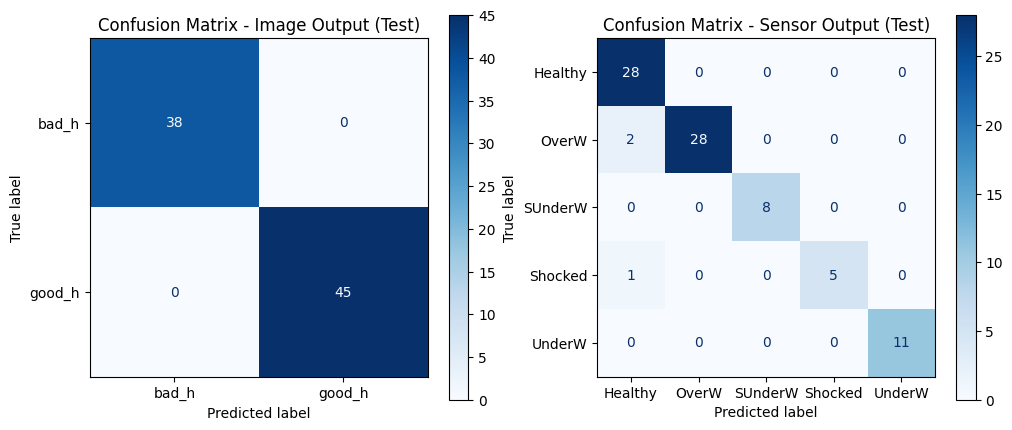

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Predict on test set
y_pred_probs_img, y_pred_probs_cond = model.predict(
    {"image_input": X_image_test, "sensor_input": X_sensor_test}, verbose=0
)

y_pred_probs_img = model.predict([X_image_test, X_sensor_test])[0]
y_pred_probs_cond = model.predict([X_image_test, X_sensor_test])[1]

y_pred_img = np.argmax(y_pred_probs_img, axis=1)
y_pred_cond = np.argmax(y_pred_probs_cond, axis=1)


# Accuracies
acc_img = accuracy_score(y_img_test, y_pred_img)
acc_cond = accuracy_score(y_cond_test, y_pred_cond)

print("Image branch accuracy:", acc_img)
print("Condition branch accuracy:", acc_cond)


# Confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay.from_predictions(
    y_img_test, y_pred_img, ax=ax[0],
    cmap="Blues", values_format="d", display_labels=IMG_LABELS
)
ax[0].set_title("Confusion Matrix - Image Output (Test)")

ConfusionMatrixDisplay.from_predictions(
    y_cond_test, y_pred_cond, ax=ax[1],
    cmap="Blues", values_format="d", display_labels=COND_LABELS_EXPECTED
)
ax[1].set_title("Confusion Matrix - Sensor Output (Test)")

plt.show()


## 11) Save Trained Model

In [16]:
MODEL_PATH = Path("sensor_image_model.h5")
model.save(MODEL_PATH)
print(f"Saved model to {MODEL_PATH.resolve()}")

Saved model to C:\Users\X415\Downloads\sensor_image_model.h5


## Optional for testing 

In [ ]:
# ==== Manual test input ====
import numpy as np

# Replace with your own sensor data (must match input shape)
test_sensor = np.array([[0.5, 0.2, 0.8, 2]])  

# Replace with your own image data (normalized, shape must match)
test_image = np.random.rand(1, *X_image.shape[1:])  

# Predict
pred_img, pred_cond = model.predict(
    {"image_input": test_image, "sensor_input": test_sensor}, verbose=0
)

# Get indices
pred_img_idx = np.argmax(pred_img, axis=1)[0]
pred_cond_idx = np.argmax(pred_cond, axis=1)[0]

# Map to class names
print("Image branch prediction:", IMG_LABELS[pred_img_idx])
print("Sensor branch prediction:", COND_LABELS_EXPECTED[pred_cond_idx])

Image branch prediction: good_h
Sensor branch prediction: Healthy


##12) Convert to ONNX for export (separate kernel)

In [4]:
import tensorflow as tf

# Load .h5
model = tf.keras.models.load_model('C:/Users/X415/Downloads/sensor_image_model.h5')

# Save as TensorFlow SavedModel directory
model.save('C:/Users/Hercu/Downloads/saved_model_dir')


TypeError: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'depthwise_regularizer': None, 'depthwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}

##13) Convert to ONNX for export (separate kernel)

In [ ]:
#in cmd using python 3.10
python -m tf2onnx.convert --saved-model C:/Users/X415/Downloads/saved_model_dir --output model.onnx --opset 13